# Time series prediction

The idea is to make a model which predicts the close price of NASDAQ. <br />
The data is taken from [Kaggle](https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset).

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_algorithms.optimizers import COBYLA

from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit.library import TwoLocal
import pandas as pd
# from scipy.signal import argrelextrema

import tabulate
from sklearn.model_selection import train_test_split

## 1. Preprocessing

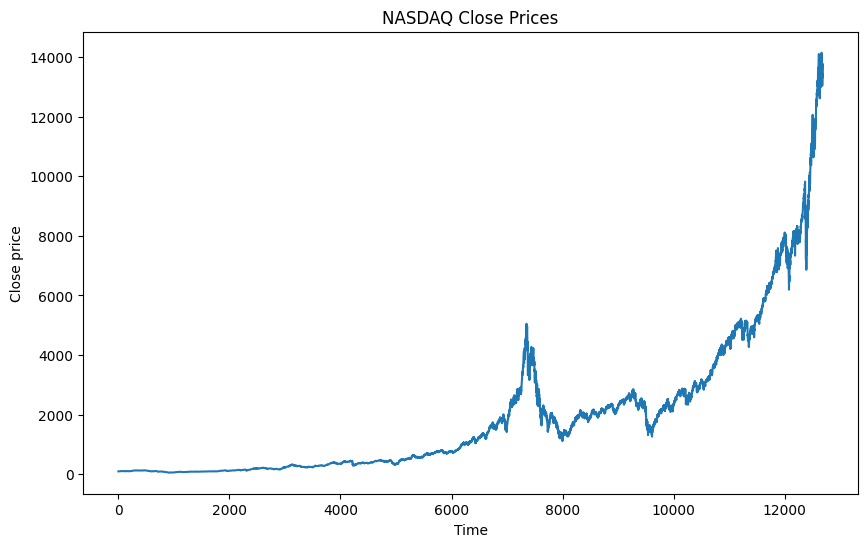

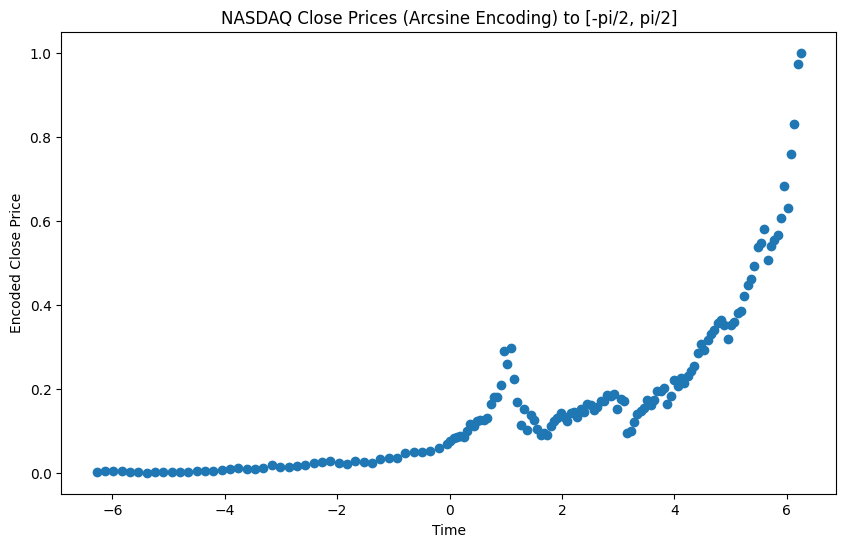

In [28]:

stock_data = pd.read_csv('./data/indexData.csv')  
nasdaq_data = stock_data[stock_data['Index'] == 'IXIC']
close_prices = nasdaq_data['Close'].values  
x = np.arange(len(close_prices)) 

plt.figure(figsize=(10, 6))
plt.plot(x, close_prices)
plt.title("NASDAQ Close Prices")
plt.xlabel("Time")
plt.ylabel("Close price")
plt.show()

# normalize close prices to range [0, 2*pi]
max_close_price = max(close_prices)
y = (close_prices / max_close_price) * 2 * np.pi  # normalize data to [0, 2*pi]


"""
order = 50
local_minima = argrelextrema(close_prices, np.less, order=order)[0]
local_maxima = argrelextrema(close_prices, np.greater, order=order)[0]
plt.figure(figsize=(10, 6))
plt.plot(close_prices, label="Close Prices")
plt.scatter(local_minima, close_prices[local_minima], marker='o', color='red', label="Local Minima")
plt.scatter(local_maxima, close_prices[local_maxima], marker='o', color='green', label="Local Maxima")
plt.title("Local Minima and Maxima of Stock Prices")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()
num_extrema = len(local_minima) + len(local_maxima)

x_points = np.concatenate((local_minima, local_maxima))
y_points = close_prices[x_points]
"""


def progressive_downsampling(x, y, start_factor=200, end_factor=1):
    n = len(x)
    downsampled_x = []
    downsampled_y = []
    
    mid_point = int(n * 0.5)  
    
    for i in range(mid_point): # heavy downsampling at the start
        if i % start_factor == 0:
            downsampled_x.append(x[i])
            downsampled_y.append(y[i])
    
    for i in range(mid_point, n): # light downsampling at the end
        if i % end_factor == 0:
            downsampled_x.append(x[i])
            downsampled_y.append(y[i])

    return np.array(downsampled_x), np.array(downsampled_y)

x_points, y_points = progressive_downsampling(x, y, start_factor=150, end_factor=60) # (100, 60) works well, (1, 1) has no effect

# normalize the x_points to [-2*pi, 2*pi]
x_points = (x_points / len(close_prices)) * 4 * np.pi - 2 * np.pi
# rescale y to [0, 1] 
y_points = (y_points - np.min(y_points)) / (np.max(y_points) - np.min(y_points))

plt.figure(figsize=(10, 6))
plt.plot(x_points, y_points, 'o')
plt.title("NASDAQ Close Prices (Arcsine Encoding) to [-pi/2, pi/2]")
plt.xlabel("Time")
plt.ylabel("Encoded Close Price")
plt.show()


"""
# remove all y points where y < 0.2 this makes the plateau less pronounced
x_points_temp = x_points
y_points_temp = y_points
x_points = []
y_points = []
for i in range(len(y_points_temp)):
    if y_points_temp[i] > 0.2:
        x_points.append(x_points_temp[i])
        y_points.append(y_points_temp[i])
"""


X_train, X_test, y_train, y_test = train_test_split(np.array(x_points), np.array(y_points), test_size=0.2, random_state=42)
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

## 2. Circuit design

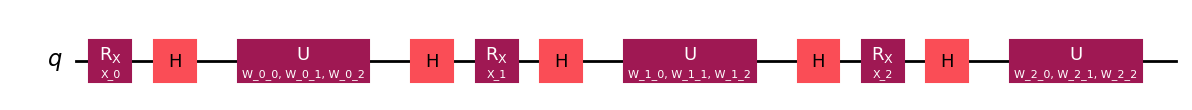

In [138]:
def serial_1_qubit_n_repetitions_model(n): # data reuploading
    # note that the feautre map and ansatz included in the model qc
    qc = QuantumCircuit(1)
    START = True
 
    # data encoding block
    def S(label, id):
        nonlocal START
        param_x = Parameter(f"{label}_{id}") 
        if not START: qc.h(0)
        else: START = False # because on the real device, we can't use Hadamard as the first gate
        qc.rx(param_x, 0)
        qc.h(0)

    # trainable variational block
    def W(label, id):
        param_w_0 = Parameter(f"{label}_{id}_0") 
        param_w_1 = Parameter(f"{label}_{id}_1")
        param_w_2 = Parameter(f"{label}_{id}_2")
        qc.u(param_w_0, param_w_1, param_w_2, 0)

    unique_id = 0
    for _ in range(n):
        S('X', unique_id)
        W('W', unique_id)       
        unique_id += 1           

    #W('W', unique_id)

    return qc

def parallel_n_qubit_1_repetition_model(layers): # data encoding repetition
    param_x = Parameter("X")
    feature_map = QuantumCircuit(layers, name="fm")

    param_y = Parameter("y")
    ansatz = QuantumCircuit(layers, name="vf")

    unique_id = 0
    START = True

    # data encoding block
    def S(label):
        nonlocal unique_id, START
        for l in range(layers):
            param_x = Parameter(label + "_" + str(unique_id))
            unique_id += 1
            if not START: feature_map.h(l)
            feature_map.rx(param_x, l)
            feature_map.h(l)

        START = False
            
    # trainable variational block
    def W(label):
        nonlocal unique_id
        rotation_params = []
        entangling_params = []

        for l in range(layers):
            ansatz.h(l)
        
        for i in range(layers):
            rotation_params.append(Parameter(label+'['+str(unique_id)+']'))
            unique_id += 1
        for i in range(layers - 1):
            entangling_params.append(Parameter(label+'['+str(unique_id)+']'))
            unique_id += 1
        
        two_local_layer = TwoLocal( # using TwoLocal circuit
            num_qubits=layers,  
            entanglement='full', 
            reps=1,  
        )

        for i, param in enumerate(rotation_params): # rotation layer
            two_local_layer.ry(param, i)  
            two_local_layer.rz(param, i)  

        for i in range(layers - 1): # entanglement layer
            two_local_layer.cx(i, i + 1) 

        ansatz.append(two_local_layer, range(layers))
        
    W('W')
    S('X')       
    W('W')

    return feature_map, ansatz 

repetitions = 3 # 1, 3, 5

# serial encoding
qc_serial = serial_1_qubit_n_repetitions_model(repetitions)
input_params = [param for param in qc_serial.parameters if "X" in str(param)]  # data encoding parameters
weight_params = [param for param in qc_serial.parameters if "W" in str(param)]  # variational parameters
regression_estimator_qnn_serial = EstimatorQNN(circuit=qc_serial, input_params=input_params, weight_params=weight_params)
regressor_serial = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn_serial,
    loss="squared_error",
    optimizer=COBYLA(maxiter=80),
    callback=callback_graph,
)

# parallel encoding
feature_map_parallel, ansatz_parallel = parallel_n_qubit_1_repetition_model(repetitions)
qc_parallel = QNNCircuit(feature_map=feature_map_parallel, ansatz=ansatz_parallel)
regression_estimator_qnn_parallel = EstimatorQNN(circuit=qc_parallel)
regressor_parallel = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn_parallel,
    loss="squared_error",
    optimizer=COBYLA(maxiter=80),
    callback=callback_graph,
)

qc_parallel.draw('mpl')
qc_serial.draw('mpl')


## 3. Training

### 3.1 Sequential

#### 3.1.1 Linear encoding

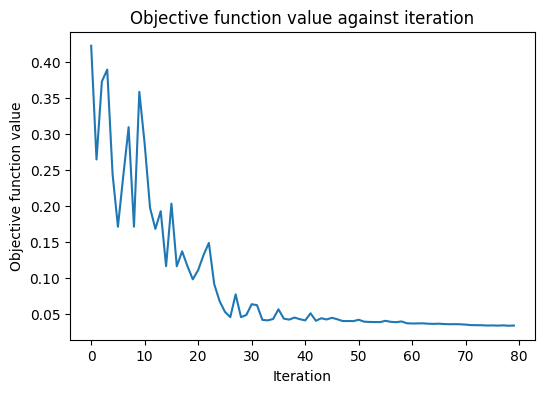

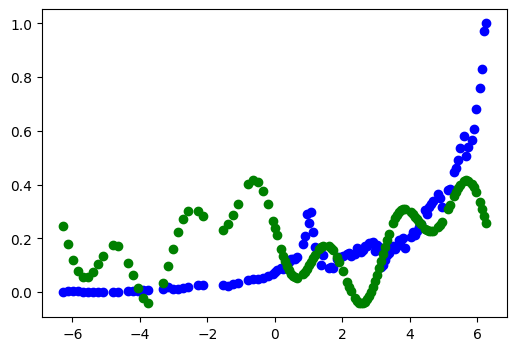

14.551142871622824
29.29225648209678


In [ ]:
X_train_repeated = np.repeat(X_train, repetitions, axis=1)
X_test_repeated = np.repeat(X_test, repetitions, axis=1)

objective_func_vals = []
regressor_serial.fit(X_train_repeated, y_train)

plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(X_train, y_train, "bo")

y_ = regressor_serial.predict(X_train_repeated)
plt.plot(X_train, y_, "go")
plt.show()

print(regressor_serial.score(X_train_repeated, y_train) * 100)
print(regressor_serial.score(X_test_repeated, y_test) * 100)



#### 3.1.2 Arcsine encoding

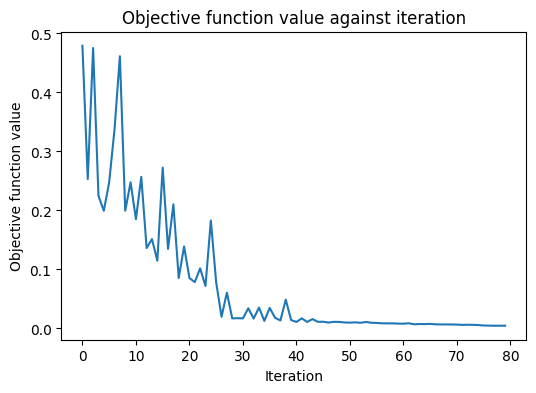

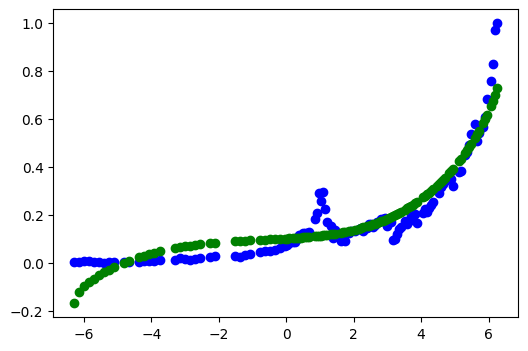

88.41551059809262
94.14008099683397


In [140]:
a = 1
b = 0
def arcsine_encode(x):
    return np.arcsin((a * x + b) / (2 * np.pi))

X_train_repeated = np.repeat(arcsine_encode(X_train), repetitions, axis=1)
X_test_repeated = np.repeat(arcsine_encode(X_test), repetitions, axis=1)

objective_func_vals = []
regressor_serial.fit(X_train_repeated, y_train)

plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(X_train, y_train, "bo")

y_ = regressor_serial.predict(X_train_repeated)
plt.plot(X_train, y_, "go")
plt.show()

print(regressor_serial.score(X_train_repeated, y_train) * 100)
print(regressor_serial.score(X_test_repeated, y_test) * 100)

### 3.2 Parallel

#### 3.2.1 Linear encoding

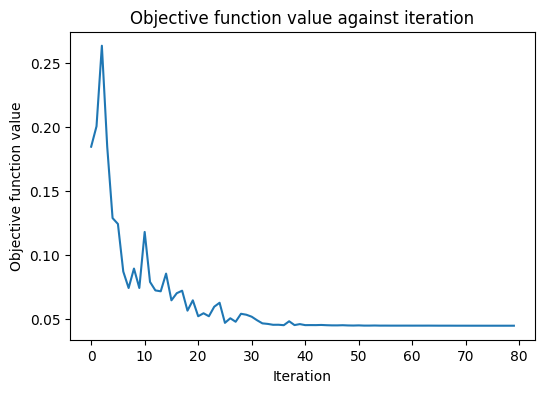

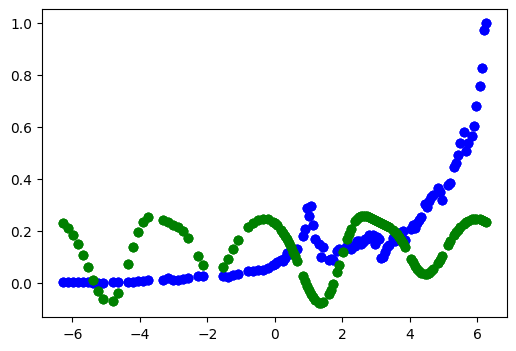

-10.676994434998853


In [141]:
objective_func_vals = []
X_train_repeated = np.repeat(X_train, repetitions, axis=1)
X_test_repeated = np.repeat(X_test, repetitions, axis=1)

regressor_parallel.fit(X_train_repeated, y_train)

plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(X_train_repeated, y_train, "bo")

y_ = regressor_parallel.predict(X_train_repeated)
plt.plot(X_train_repeated, y_, "go")
plt.show()

print(regressor_parallel.score(X_test_repeated, y_test) * 100)


#### 3.2.2 Arcsine encoding

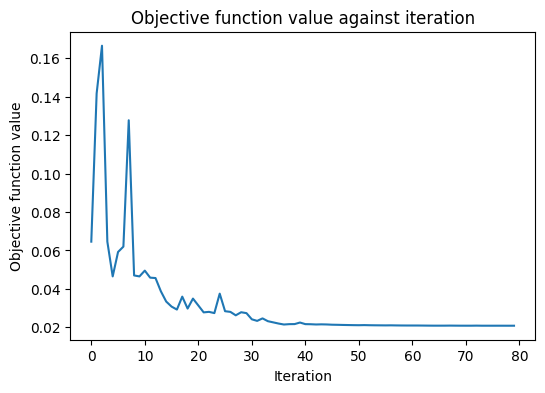

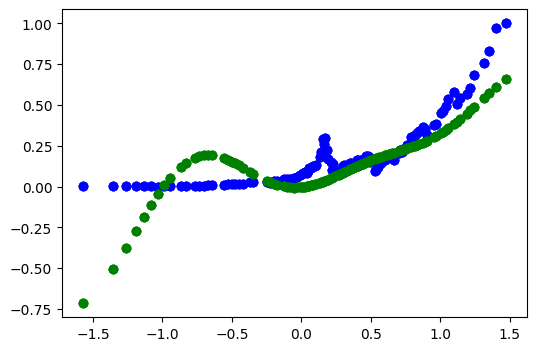

70.66130742491809


In [142]:
a = 1
b = 0
def arcsine_encode(x):
    return np.arcsin((a * x + b) / (2 * np.pi))

X_train_repeated = np.repeat(arcsine_encode(X_train), repetitions, axis=1)
X_test_repeated = np.repeat(arcsine_encode(X_test), repetitions, axis=1)

objective_func_vals = []
regressor_parallel.fit(X_train_repeated, y_train)

plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(X_train_repeated, y_train, "bo")

y_ = regressor_parallel.predict(X_train_repeated)
plt.plot(X_train_repeated, y_, "go")
plt.show()

print(regressor_parallel.score(X_test_repeated, y_test) * 100)


## 4. Analysis

In [ ]:
max_repetitions = 10

header = ["Regressor", "Encoding", "Repetitions", "Train Score", "Test Score"]
table = []

a = 1
b = 0
def arcsine_encode(x):
    return np.arcsin((a * x + b) / (2 * np.pi))
def linear_encode(x):
    return x 

for repetition in range(1, max_repetitions + 1):
    print(f"Repetition: {repetition}")
    qc_serial = serial_1_qubit_n_repetitions_model(repetition)
    input_params = [param for param in qc_serial.parameters if "X" in str(param)]  # data encoding parameters
    weight_params = [param for param in qc_serial.parameters if "W" in str(param)]  # variational parameters
    regression_estimator_qnn_serial = EstimatorQNN(circuit=qc_serial, input_params=input_params, weight_params=weight_params)
    regressor_serial = NeuralNetworkRegressor(
        neural_network=regression_estimator_qnn_serial,
        loss="squared_error",
        optimizer=COBYLA(maxiter=60),
    )

    feature_map_parallel, ansatz_parallel = parallel_n_qubit_1_repetition_model(repetition)
    qc_parallel = QNNCircuit(feature_map=feature_map_parallel, ansatz=ansatz_parallel)
    regression_estimator_qnn_parallel = EstimatorQNN(circuit=qc_parallel)
    regressor_parallel = NeuralNetworkRegressor(
        neural_network=regression_estimator_qnn_parallel,
        loss="squared_error",
        optimizer=COBYLA(maxiter=60),
    )

    X_train_repeated_linear = np.repeat(linear_encode(X_train), repetition, axis=1)
    X_test_repeated_linear = np.repeat(linear_encode(X_test), repetition, axis=1)
    X_train_repeated_arcsine = np.repeat(arcsine_encode(X_train), repetition, axis=1)
    X_test_repeated_arcsine = np.repeat(arcsine_encode(X_test), repetition, axis=1)
    X_train_linear = linear_encode(X_train)
    X_test_linear = linear_encode(X_test)
    X_train_arcsine = arcsine_encode(X_train)
    X_test_arcsine = arcsine_encode(X_test)

    print("(i) Fitting with linear scaling...")
    regressor_serial.fit(X_train_repeated_linear, y_train)
    regressor_parallel.fit(X_train_repeated_linear, y_train)

    train_score_serial = regressor_serial.score(X_train_repeated_linear, y_train) * 100
    test_score_serial = regressor_serial.score(X_test_repeated_linear, y_test) * 100
    train_score_parallel = regressor_parallel.score(X_train_repeated_linear, y_train) * 100
    test_score_parallel = regressor_parallel.score(X_test_repeated_linear, y_test) * 100

    table.append(["Serial", "Linear", repetition, train_score_serial, test_score_serial])
    table.append(["Parallel", "Linear", repetition, train_score_parallel, test_score_parallel])

    print(tabulate.tabulate(table, headers=header, tablefmt="pretty"))

    print("(i) Fitting with arcsine scaling...")
    regressor_serial.fit(X_train_repeated_arcsine, y_train)
    regressor_parallel.fit(X_train_repeated_arcsine, y_train)

    train_score_serial = regressor_serial.score(X_train_repeated_arcsine, y_train) * 100
    test_score_serial = regressor_serial.score(X_test_repeated_arcsine, y_test) * 100
    train_score_parallel = regressor_parallel.score(X_train_repeated_arcsine, y_train) * 100
    test_score_parallel = regressor_parallel.score(X_test_repeated_arcsine, y_test) * 100

    table.append(["Serial", "Arcsine", repetition, train_score_serial, test_score_serial])
    table.append(["Parallel", "Arcsine", repetition, train_score_parallel, test_score_parallel])

    print(tabulate.tabulate(table, headers=header, tablefmt="pretty"))

    

Repetition: 1
(i) Fitting with linear scaling...
+-----------+----------+-------------+--------------------+--------------------+
| Regressor | Encoding | Repetitions |    Train Score     |     Test Score     |
+-----------+----------+-------------+--------------------+--------------------+
|  Serial   |  Linear  |      1      | -72.42727600912657 | -76.7635843937996  |
| Parallel  |  Linear  |      1      | -71.47015566437751 | -73.11285125948896 |
+-----------+----------+-------------+--------------------+--------------------+
(i) Fitting with arcsine scaling...
+-----------+----------+-------------+--------------------+--------------------+
| Regressor | Encoding | Repetitions |    Train Score     |     Test Score     |
+-----------+----------+-------------+--------------------+--------------------+
|  Serial   |  Linear  |      1      | -72.42727600912657 | -76.7635843937996  |
| Parallel  |  Linear  |      1      | -71.47015566437751 | -73.11285125948896 |
|  Serial   | Arcsine  |

In [10]:
best_model = max(table, key=lambda x: x[4])

print(f"Best model: {best_model[0]} with encoding {best_model[1]} and {best_model[2]} repetitions")
print(f"Train score: {best_model[3]}, Test score: {best_model[4]}")

Best model: Serial with encoding Arcsine and 4 repetitions
Train score: 89.34088955723185, Test score: 94.08682781903948


In [11]:
best_serial_linear_model = [row for row in table if row[0] == "Serial" and row[1] == "Linear" and row[2] == best_model[2]][0]

print(f"Best serial linear model: {best_serial_linear_model[0]} with encoding {best_serial_linear_model[1]} and {best_serial_linear_model[2]} repetitions")
print(f"Train score: {best_serial_linear_model[3]}, Test score: {best_serial_linear_model[4]}")

Best serial linear model: Serial with encoding Linear and 4 repetitions
Train score: 5.374026621186578, Test score: -2.5592802119449365


### Upperbounds on expressivity

In [12]:
"""
K <= d^(2L) / 2 - 1
L: Amount of repetitions (layers in serial model)
d: Gate dimension (2 for single qubit gates)
"""
L = best_model[2]
d = 2 # single qubit gates
K_serial_arcsine = (2 ** (2 * 3)) / 2 - 1
print(f"K = {K_serial_arcsine}")

K = 31.0


## Running it on a real quantum computer

PrimitiveResult([SamplerPubResult(data=DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=1>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([SliceSpan(<start='2024-12-30 22:53:48', stop='2024-12-30 22:55:21', size=1024>)])}, 'version': 2})


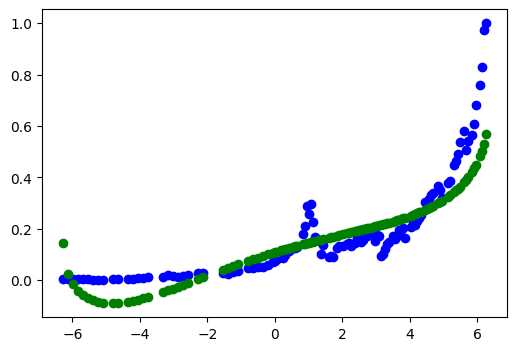

Train score: 75.47019594931325, Test score: 83.63366089902205


In [126]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit import transpile
from qiskit.circuit import ClassicalRegister

a = 1
b = 0
def arcsine_encode(x):
    return np.arcsin((a * x + b) / (2 * np.pi))

service = QiskitRuntimeService(
    channel='ibm_quantum',
    token='...'
)

backend = service.backend(name='ibm_brisbane')
sampler = Sampler(backend)

repetition = 3

qc_serial = serial_1_qubit_n_repetitions_model(repetition)
input_params = [param for param in qc_serial.parameters if "X" in str(param)]  # data encoding parameters
weight_params = [param for param in qc_serial.parameters if "W" in str(param)]  # variational parameters
regression_estimator_qnn_serial = EstimatorQNN(circuit=qc_serial, input_params=input_params, weight_params=weight_params)
regressor_serial = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn_serial,
    loss="squared_error",
    optimizer=COBYLA(maxiter=60),
)

X_train_repeated_arcsine = np.repeat(arcsine_encode(X_train), repetition, axis=1)
X_test_repeated_arcsine = np.repeat(arcsine_encode(X_test), repetition, axis=1)

model = regressor_serial.fit(X_train_repeated_arcsine, y_train)
 
train_score_serial = regressor_serial.score(X_train_repeated_arcsine, y_train) * 100
test_score_serial = regressor_serial.score(X_test_repeated_arcsine, y_test) * 100
input_values = np.array(arcsine_encode(np.array([-2, -2, -2])))

params = [param for param in model.weights]
for input in input_values:
    params.append(input)

qc_serial.add_register(ClassicalRegister(1)) 
qc_serial.measure(0, 0)
transpiled_circuit = transpile(qc_serial, backend=backend)
res = sampler.run([(transpiled_circuit, params)], shots=1024).result()
   
print(res)

plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(X_train, y_train, "bo")
y_ = regressor_serial.predict(X_train_repeated_arcsine)
plt.plot(X_train, y_, "go")
plt.show()

print(f"Train score: {train_score_serial}, Test score: {test_score_serial}")

Probability of 0: 0.4970703125, Probability of 1: 0.5029296875


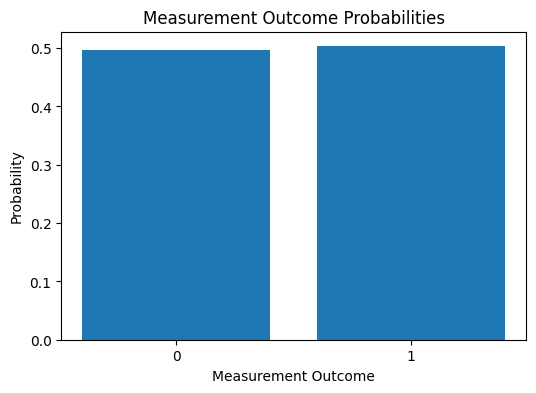

In [134]:
bit_array = res[0].data.c2.bitcount()
count_0 = np.sum(bit_array == 0)
count_1 = np.sum(bit_array == 1)
prob_0 = count_0 / len(bit_array)
prob_1 = count_1 / len(bit_array)

print(f"Probability of 0: {prob_0}, Probability of 1: {prob_1}")
labels = ['0', '1']
probabilities = [prob_0, prob_1]

plt.bar(labels, probabilities)
plt.xlabel('Measurement Outcome')
plt.ylabel('Probability')
plt.title('Measurement Outcome Probabilities')
plt.show()
